# Data Analysis and Price Forecasting of Crude Oil

In this notebook we will be deploying a model to forecast the price of Crude Oil and carry out analysis for effective hedging of crude oil.

**Importing necessary libraries**

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


**Loading the data**

Crudeoil is the target variable that we got to predict and we are going to use 6 features to do that (Gold, Silver, ChinaOilCorp, BTC(Bitcoin), Usdollar, NaturalGas).

In [2]:
data=pd.read_csv(r"dataset.csv")
data.head()

,Crudeoil,Gold,Silver,ChinaOilCorp,BTC,Usdollar,NaturalGas
0,78.44,17.15,7.28,5.05,"62,125.20",104.83,17.17
1,78.26,16.91,7.29,5.09,"60,826.60",105.31,16.52
2,78.11,16.45,6.70,4.68,"63,888.30",105.08,15.68
3,83.85,17.09,7.04,4.80,"63,456.80",106.09,14.06
4,83.14,17.10,6.73,4.65,"64,961.10",106.12,14.52


**Data Preprocessing**

We are going to process all our data to handle missing values and to ensure consistency of data type(float).

In [3]:
for column in data.columns:
    try:
        data[column] = data[column].str.replace(',', '').astype(float)
    except AttributeError:
        continue
    except ValueError:
        continue

Some of our data is of very high values and some arent hence we scale all of them to fit in range 0 to 1.

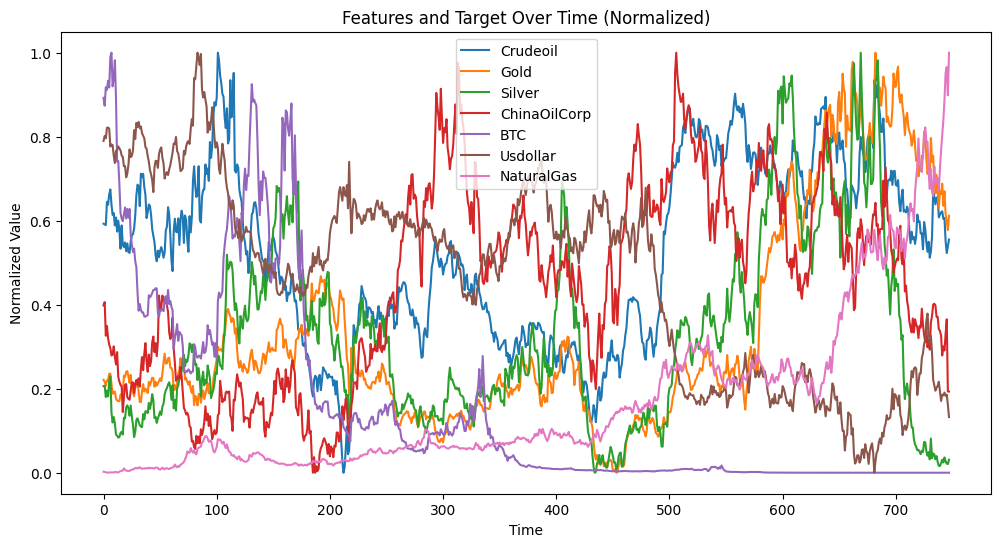

In [4]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)
plt.figure(figsize=(12, 6))
for column in data_scaled.columns:
    plt.plot(data_scaled[column], label=column)
plt.title('Features and Target Over Time (Normalized)')
plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()


**Deploying the model**

We are going to use RNN model as the relation of Crude Oil with other features is non linear hence we need a model that captures the complex relations of the features with the target.

We are going to split the data into training and testing samples.

In [5]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 1:])
        y.append(data[i, 0])
    return np.array(X), np.array(y)
n_steps = 10
X, y = create_sequences(data_scaled, n_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Model architecture tuning
model = Sequential([
    # LSTM layer with 50 units
    LSTM(50, activation='relu', input_shape=(n_steps, 6), return_sequences=True),  # return_sequences=True for stacked LSTM
    Dropout(0.2),  # Introduce dropout layer to prevent overfitting
    # LSTM layer with 50 units
    LSTM(50, activation='relu'),  # You can experiment with adding more LSTM layers
    Dropout(0.2),  # Introduce dropout layer to prevent overfitting
    Dense(1)
])

**Testing**

Now we are going to test our model on MSE(mean square error) and RMSE(root mean square error) and R^2 Score.

In [19]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.1)

# Testing
test_mse = model.evaluate(X_test, y_test, verbose=0)
print("Test MSE:", test_mse)
predictions = model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, predictions))
print("Test RMSE:", rmse)


Epoch 1/50
17/17 [==============================] - 4s 58ms/step - loss: 0.0071 - val_loss: 0.0034
Epoch 2/50
17/17 [==============================] - 0s 15ms/step - loss: 0.0064 - val_loss: 0.0031
Epoch 3/50
17/17 [==============================] - 0s 14ms/step - loss: 0.0062 - val_loss: 0.0036
Epoch 4/50
17/17 [==============================] - 0s 13ms/step - loss: 0.0057 - val_loss: 0.0027
Epoch 5/50
17/17 [==============================] - 0s 14ms/step - loss: 0.0068 - val_loss: 0.0031
Epoch 6/50
17/17 [==============================] - 0s 14ms/step - loss: 0.0061 - val_loss: 0.0034
Epoch 7/50
17/17 [==============================] - 0s 13ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 8/50
17/17 [==============================] - 0s 14ms/step - loss: 0.0071 - val_loss: 0.0043
Epoch 9/50
17/17 [==============================] - 0s 14ms/step - loss: 0.0068 - val_loss: 0.0032
Epoch 10/50
17/17 [==============================] - 0s 13ms/step - loss: 0.0060 - val_loss: 0.0024
Epoch 11/

In [8]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"Model R² Score: {r2:.2f} (Percentage: {r2 * 100:.2f}%)")

5/5 [==============================] - 0s 3ms/step
Model R² Score: 0.93 (Percentage: 93.50%)


MSE and RMSE values near to 0 and R^2 values near to 1 indicates that our model is a good fit.

Plot of actual v/s prediced values.

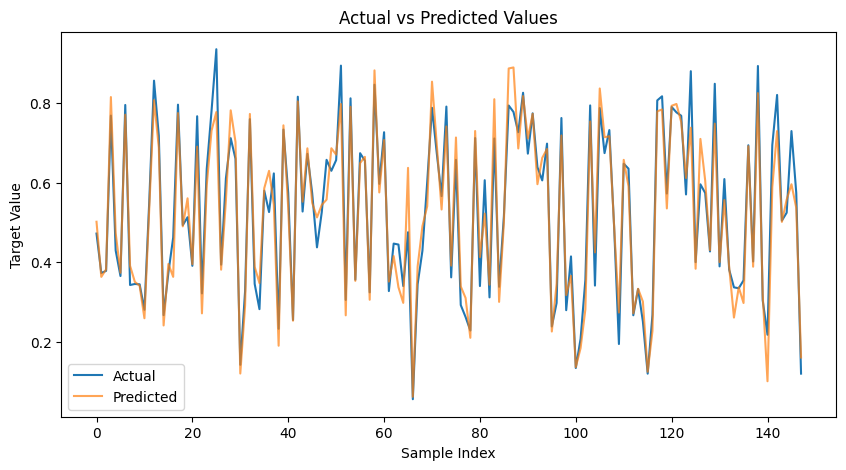

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()

**Analysis of the rseults**

To determine how each feature effects out result we need to know the impact and importance of each feature in forecasting thus we remove the MSE by excluding each feature from predicting the target variable. Higher the MSE caused by absence of that feature higher would be the importance of that feature.

In [10]:
def feature_ablation_study(model, X, y, feature_indices):
    original_preds = model.predict(X)
    original_mse = mean_squared_error(y, original_preds)
    name=["Gold","Silver","ChinaoilCorp","BTC","Usodollar","Naturalgas"]
    results = {}
    for idx in feature_indices:
        X_new = np.copy(X)
        X_new[:, :, idx] = np.mean(X_new[:, :, idx])
        new_preds = model.predict(X_new)
        new_mse = mean_squared_error(y, new_preds)
        results[name[idx]] = new_mse

    return results


feature_indices = list(range(6))
ablation_results = feature_ablation_study(model, X_test, y_test, feature_indices)
print(ablation_results)


5/5 [==============================] - 0s 3ms/step
{'Gold': 0.014117365600520147, 'Silver': 0.006474446924987673, 'ChinaoilCorp': 0.010652062022014581, 'BTC': 0.027507052101733265, 'Usodollar': 0.017112266415768556, 'Naturalgas': 0.030856118894890455}


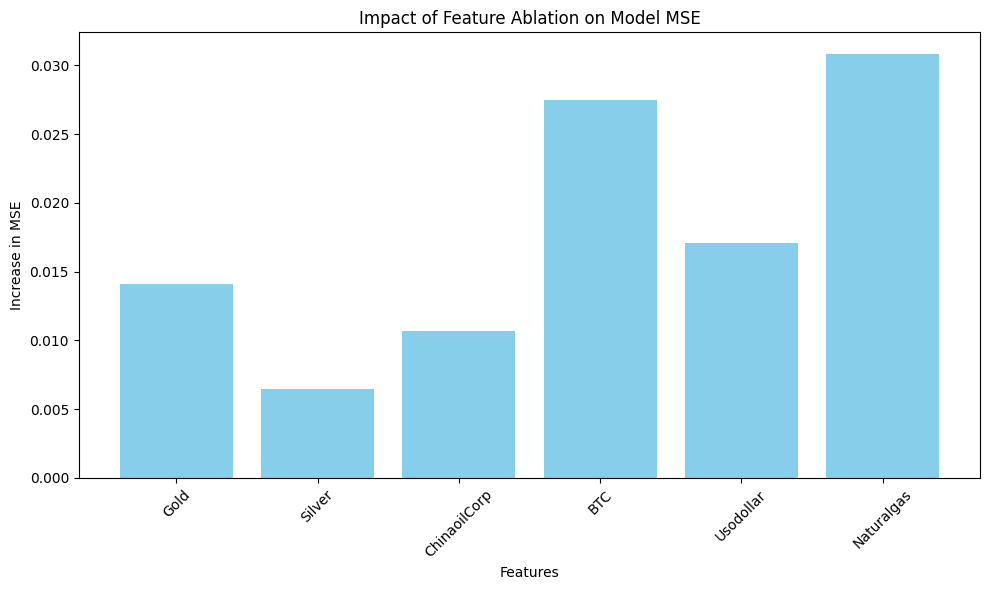

In [11]:
features = list(ablation_results.keys())
mse_increases = list(ablation_results.values())

plt.figure(figsize=(10, 6))
plt.bar(features, mse_increases, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Increase in MSE')
plt.title('Impact of Feature Ablation on Model MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the following plot we can conclude that USdollar is the most important feature for forcasting CrudeOil price followed by BTC(Bitcoin) and Naturalgas.

Now for determining individual Feature's relation with target Variablle we are going to remove the correlation of each feature with the target.

Correlation of each feature with the target:
Gold            0.451726
Silver          0.432395
ChinaOilCorp    0.260357
BTC             0.049652
Usdollar       -0.495536
NaturalGas      0.415949
Name: Crudeoil, dtype: float64


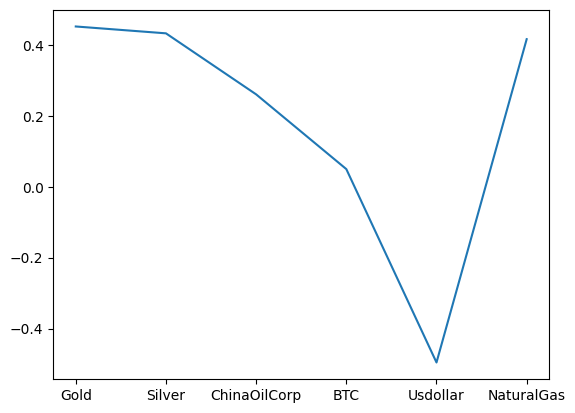

In [12]:
data_scaled = data.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
correlation_matrix = data_scaled.corr()
feature_target_correlation = correlation_matrix.iloc[0, 1:]
print("Correlation of each feature with the target:")
print(feature_target_correlation)
plt.plot(feature_target_correlation)

Gold and Silver showing positive correlations with crude oil. These commodities are often correlated because they can be influenced similarly by global economic factors such as inflation rates, economic stability, and changes in the dollar value.

ChinaOilCorp is slighlty positive somewhat correlated with global oil prices but also heavily influenced by company-specific factors and local market conditions, which might dilute the correlation.

US dollar has negative correlation. Oil is priced in USD globally, so when the dollar strengthens, oil becomes more expensive in other currencies, potentially reducing demand and thus the price. Conversely, a weaker dollar can boost oil prices. This inverse relationship is a well-established economic pattern. Thus, USD can be used as an effective Hedge against Crude Oil.

Natural gas is a major energy commodity, and their prices often move in sync due to linked demand.

# Additional Visualisations

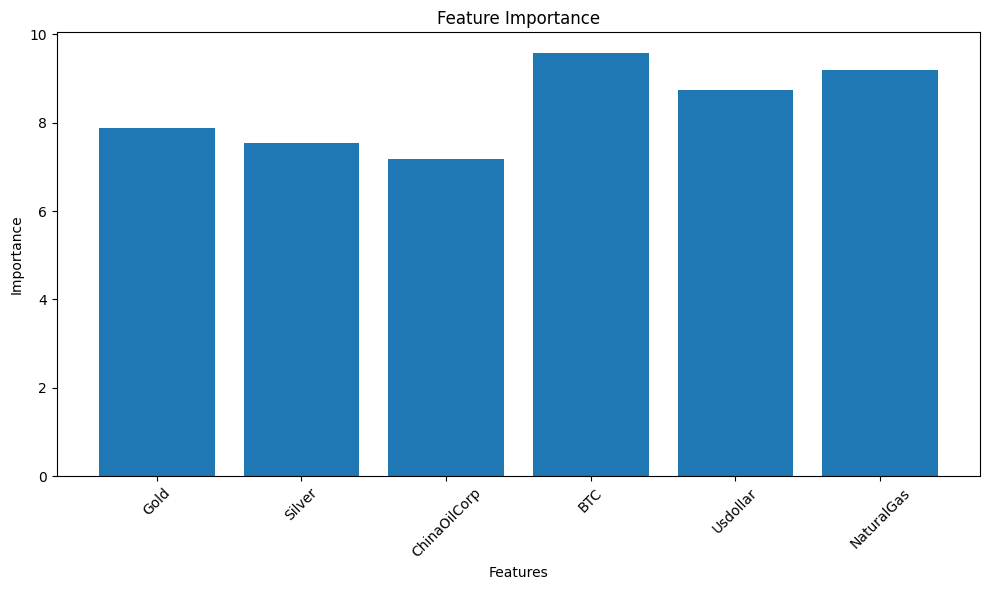

In [13]:
# Extracting weights from the model
weights_input_hidden = model.layers[0].get_weights()[0]

# Calculating feature importance as the absolute sum of weights for each feature
feature_importance = np.abs(weights_input_hidden).sum(axis=1)

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.bar(data.columns[1:], feature_importance)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


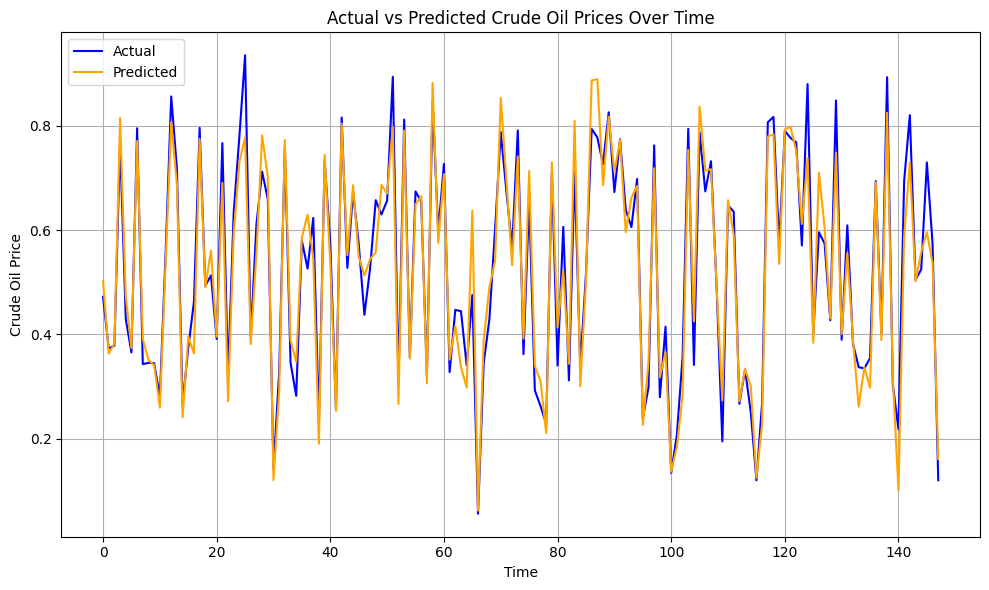

In [14]:
# Actual vs Predicted Plot Over Time
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='orange')
plt.title('Actual vs Predicted Crude Oil Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Crude Oil Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

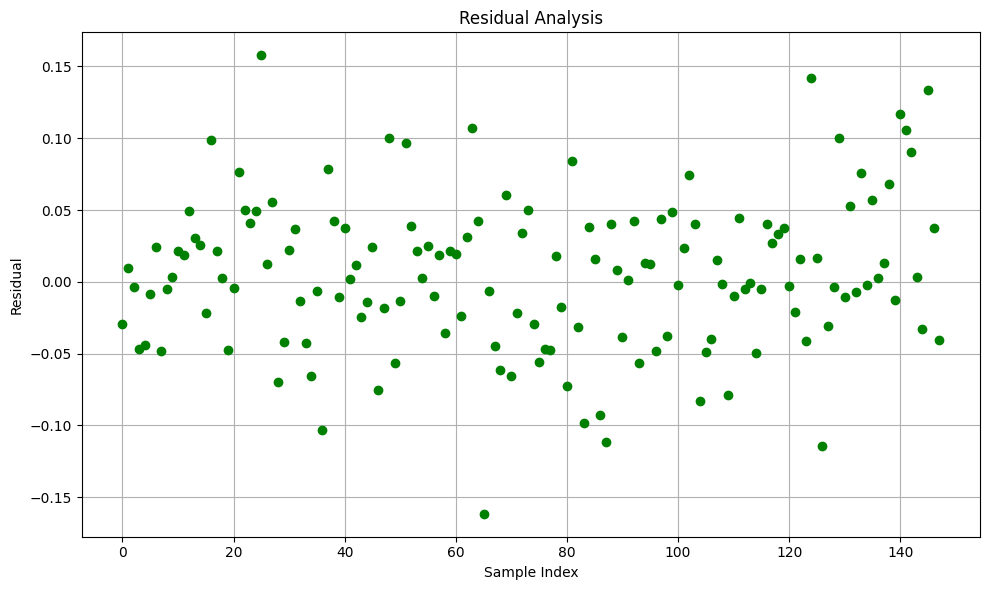

In [15]:
# Residual Analysis
residuals = y_test - predictions.reshape(-1)
plt.figure(figsize=(10, 6))
plt.plot(residuals, marker='o', linestyle='None', color='green')
plt.title('Residual Analysis')
plt.xlabel('Sample Index')
plt.ylabel('Residual')
plt.grid(True)
plt.tight_layout()
plt.show()